In [2]:
from sqlalchemy import create_engine, Column, Integer, Float, String, Boolean, ForeignKey, func, desc
from sqlalchemy.orm import sessionmaker, relationship, declarative_base

# Define the base class
Base = declarative_base()

In [3]:
# Define ORM classes
class Vintage(Base):
    __tablename__ = 'vintages'
    id = Column(Integer, primary_key=True)
    name = Column(String)
    wine_id = Column(Integer, ForeignKey('wines.id'))
    ratings_average = Column(Float)
    ratings_count = Column(Integer)
    year = Column(Integer)
    price_euros = Column(Float)
    price_discounted_from = Column(Float)
    price_discount_percentage = Column(Float)
    bottle_volume_ml = Column(Integer)

class Wine(Base):
    __tablename__ = 'wines'
    id = Column(Integer, primary_key=True)
    name = Column(String)
    is_natural = Column(Boolean)
    region_id = Column(Integer, ForeignKey('regions.id'))
    winery_id = Column(Integer, ForeignKey('wineries.id'))
    ratings_average = Column(Float)
    ratings_count = Column(Integer)
    url = Column(String)
    acidity = Column(Float)
    fizziness = Column(Float)
    intensity = Column(Float)
    sweetness = Column(Float)
    tannin = Column(Float)
    user_structure_count = Column(Integer)

class Country(Base):
    __tablename__ = 'countries'
    code = Column(String, primary_key=True)
    name = Column(String)
    regions_count = Column(Integer)
    users_count = Column(Integer)
    wines_count = Column(Integer)
    wineries_count = Column(Integer)
    # Relationships
    regions = relationship("Region", backref="country")
    top_lists = relationship("TopList", backref="country")
    most_used_grapes = relationship("MostUsedGrapes", backref="country")

class Region(Base):
    __tablename__ = 'regions'
    id = Column(Integer, primary_key=True)
    name = Column(String)
    country_code = Column(String, ForeignKey('countries.code'))
    # Relationship
    wines = relationship("Wine", backref="region")

class Winery(Base):
    __tablename__ = 'wineries'
    id = Column(Integer, primary_key=True)
    name = Column(String)
    # Relationship
    wines = relationship("Wine", backref="winery")

class Grape(Base):
    __tablename__ = 'grapes'
    id = Column(Integer, primary_key=True)
    name = Column(String)
    wines_count = Column(Integer)
    # Relationship
    most_used_grapes = relationship("MostUsedGrapes", backref="grape")

class TopList(Base):
    __tablename__ = 'toplists'
    id = Column(Integer, primary_key=True)
    name = Column(String)
    country_code = Column(String, ForeignKey('countries.code'))

class VintageTopListRanking(Base):
    __tablename__ = 'vintage_toplists_rankings'
    id = Column(Integer, primary_key=True)
    top_list_id = Column(Integer, ForeignKey('toplists.id'))
    vintage_id = Column(Integer, ForeignKey('vintages.id'))
    rank = Column(Integer)
    previous_rank = Column(Integer)

class MostUsedGrapes(Base):
    __tablename__ = 'most_used_grapes_per_country'
    id = Column(Integer, primary_key=True)
    country_code = Column(String, ForeignKey('countries.code'))
    grape_id = Column(Integer, ForeignKey('grapes.id'))

class Keyword(Base):
    __tablename__ = 'keywords'
    id = Column(Integer, primary_key=True)
    name = Column(String)
    # Relationship
    keywords_wine = relationship("KeywordsWine", backref="keyword")

class KeywordsWine(Base):
    __tablename__ = 'keywords_wine'
    id = Column(Integer, primary_key=True)
    keyword_type = Column(String)
    count = Column(Integer)
    keyword_id = Column(Integer, ForeignKey('keywords.id'))
    wine_id = Column(Integer, ForeignKey('wines.id'))
    group_name = Column(String)

In [4]:
# Create engine and bind session
engine = create_engine('sqlite:///vivino.db')

# Now, reflect the tables to make sure the definitions are correct and all relationships are established.
Base.metadata.create_all(engine)

Session = sessionmaker(bind=engine)
session = Session()

In [5]:
# highlight 10 wines based on ratings and number of ratings (likely popular and well-regarded by customers)
top_wines = (session.query(Wine)
             .filter(Wine.ratings_count > 50)
             .order_by(Wine.ratings_average.desc())
             .limit(10)
             .all())

for wine in top_wines:
    print(f"Wine ID: {wine.id}, Name: {wine.name}, Average Rating: {wine.ratings_average}, Ratings Count: {wine.ratings_count}")

Wine ID: 1187886, Name: Amarone della Valpolicella Classico Riserva, Average Rating: 4.8, Ratings Count: 587
Wine ID: 1611255, Name: Cabernet Sauvignon, Average Rating: 4.8, Ratings Count: 2941
Wine ID: 5806244, Name: Mágico, Average Rating: 4.8, Ratings Count: 146
Wine ID: 6534388, Name: Fratini Bolgheri Superiore, Average Rating: 4.8, Ratings Count: 153
Wine ID: 7266631, Name: Cristal Rosé Vinothèque, Average Rating: 4.8, Ratings Count: 88
Wine ID: 8023, Name: IX Estate Red, Average Rating: 4.7, Ratings Count: 2810
Wine ID: 66294, Name: Special Selection Cabernet Sauvignon, Average Rating: 4.7, Ratings Count: 41236
Wine ID: 77136, Name: Unico Reserva Especial Edición, Average Rating: 4.7, Ratings Count: 13025
Wine ID: 77137, Name: Unico, Average Rating: 4.7, Ratings Count: 45140
Wine ID: 77178, Name: Eszencia, Average Rating: 4.7, Ratings Count: 488


In [6]:
# Assuming uniqueness can be determined by a wine being the only one from a specific grape or region
unique_wines = (session.query(Wine.name, Region.name)
                .join(Region, Wine.region_id == Region.id)
                .group_by(Wine.region_id)
                .having(func.count(Wine.id) == 1)
                .limit(10)
                .all())

for wine_name, region_name in unique_wines:
    print(f"Wine Name: {wine_name}, Region: {region_name}")

Wine Name: Evenstad Reserve Pinot Noir, Region: Willamette Valley
Wine Name: Belles Soeurs Cuvée Pinot Noir, Region: Yamhill County
Wine Name: Rapture Cabernet Sauvignon, Region: Lodi
Wine Name: Howell Mountain Cabernet Sauvignon, Region: Howell Mountain
Wine Name: One Point Five Cabernet Sauvignon, Region: Stags Leap District
Wine Name: Blueline Estate Cabernet Sauvignon, Region: Calistoga
Wine Name: Hyde Vineyard Chardonnay, Region: Los Carneros
Wine Name: Bentrock Vineyard Chardonnay, Region: Sta. Rita Hills
Wine Name: Alexander Valley Cabernet Sauvignon, Region: Alexander Valley
Wine Name: Cabernet Sauvignon, Region: Columbia Valley


In [7]:
#Wine Popularity: Countries with high user ratings and a large number of ratings could indicate a more engaged and potentially lucrative market.
country_popularity = (session.query(
    Country.name,
    func.avg(Wine.ratings_average).label('average_rating'),
    func.sum(Wine.ratings_count).label('total_ratings'))
    .join(Region, Country.code == Region.country_code)
    .join(Wine, Region.id == Wine.region_id)
    .group_by(Country.name)
    .order_by(desc('average_rating'), desc('total_ratings'))
    .all())

for country, avg_rating, total_ratings in country_popularity:
    print(f"Country: {country}, Average Rating: {avg_rating}, Total Ratings: {total_ratings}")


Country: Allemagne, Average Rating: 4.5, Total Ratings: 8257
Country: Israël, Average Rating: 4.5, Total Ratings: 894
Country: États-Unis, Average Rating: 4.4905405405405405, Total Ratings: 834263
Country: Moldavie, Average Rating: 4.4799999999999995, Total Ratings: 14114
Country: Hongrie, Average Rating: 4.472727272727273, Total Ratings: 30564
Country: Afrique du Sud, Average Rating: 4.45909090909091, Total Ratings: 59995
Country: Australie, Average Rating: 4.458333333333333, Total Ratings: 52138
Country: France, Average Rating: 4.447129909365559, Total Ratings: 2124809
Country: Espagne, Average Rating: 4.443617021276595, Total Ratings: 746710
Country: Portugal, Average Rating: 4.435714285714286, Total Ratings: 62454
Country: Chili, Average Rating: 4.43125, Total Ratings: 159256
Country: Italie, Average Rating: 4.430026109660575, Total Ratings: 2135839
Country: Argentine, Average Rating: 4.417391304347826, Total Ratings: 283673
Country: Grèce, Average Rating: 4.4, Total Ratings: 610
C

In [8]:
#Market Engagement: A high number of ratings and reviews could suggest an engaged customer base.
market_engagement = (session.query(
    Country.name,
    func.sum(Wine.ratings_count).label('total_ratings'))
    .join(Region, Country.code == Region.country_code)
    .join(Wine, Region.id == Wine.region_id)
    .group_by(Country.name)
    .order_by(desc('total_ratings'))
    .all())

for country, total_ratings in market_engagement:
    print(f"Country: {country}, Total Ratings: {total_ratings}")


Country: Italie, Total Ratings: 2135839
Country: France, Total Ratings: 2124809
Country: États-Unis, Total Ratings: 834263
Country: Espagne, Total Ratings: 746710
Country: Argentine, Total Ratings: 283673
Country: Chili, Total Ratings: 159256
Country: Portugal, Total Ratings: 62454
Country: Afrique du Sud, Total Ratings: 59995
Country: Australie, Total Ratings: 52138
Country: Hongrie, Total Ratings: 30564
Country: Moldavie, Total Ratings: 14114
Country: Allemagne, Total Ratings: 8257
Country: Suisse, Total Ratings: 1047
Country: Israël, Total Ratings: 894
Country: Grèce, Total Ratings: 610
Country: Croatie, Total Ratings: 292
Country: Roumanie, Total Ratings: 166


In [9]:
#Diversity of Wine Offerings: Countries with a greater diversity of wines and wineries may represent a more vibrant market
wine_diversity = (session.query(
    Country.name,
    Country.wines_count,
    Country.wineries_count)
    .order_by(desc(Country.wines_count), desc(Country.wineries_count))
    .all())

for country, wines_count, wineries_count in wine_diversity:
    print(f"Country: {country}, Wines Count: {wines_count}, Wineries Count: {wineries_count}")


Country: France, Wines Count: 422503, Wineries Count: 67553
Country: Italie, Wines Count: 274658, Wineries Count: 42399
Country: États-Unis, Wines Count: 204060, Wineries Count: 28145
Country: Allemagne, Wines Count: 164533, Wineries Count: 13643
Country: Espagne, Wines Count: 102662, Wineries Count: 18026
Country: Australie, Wines Count: 90954, Wineries Count: 13946
Country: Chili, Wines Count: 41191, Wineries Count: 5785
Country: Portugal, Wines Count: 39847, Wineries Count: 5834
Country: Argentine, Wines Count: 36121, Wineries Count: 5339
Country: Suisse, Wines Count: 33656, Wineries Count: 3849
Country: Afrique du Sud, Wines Count: 30857, Wineries Count: 4227
Country: Hongrie, Wines Count: 16605, Wineries Count: 1923
Country: Grèce, Wines Count: 9581, Wineries Count: 1294
Country: Roumanie, Wines Count: 6841, Wineries Count: 686
Country: Croatie, Wines Count: 5880, Wineries Count: 980
Country: Israël, Wines Count: 5435, Wineries Count: 529
Country: Moldavie, Wines Count: 5055, Wine

By analyzing the results of these queries, you could decide which country to prioritize; France, Italie and États-Unis

In [10]:
'''Award for Excellence in Quality:
Criteria: Based on the highest average wine ratings.
Query: Select wineries with the highest average ratings for their wines. This reflects consistent quality across their offerings.
'''

top_quality_wineries = (session.query(
    Winery.name,
    func.avg(Wine.ratings_average).label('average_rating'))
    .join(Wine, Winery.id == Wine.winery_id)
    .group_by(Winery.name)
    .order_by(desc('average_rating'))
    .limit(3)  # You can adjust the number based on how many winners you want
    .all())

for winery, avg_rating in top_quality_wineries:
    print(f"Winery: {winery}, Average Rating: {avg_rating}")


Winery: Tenuta Tignanello 'Solaia', Average Rating: 4.5
Winery: Corte di Cama Sforzato di Valtellina, Average Rating: 4.5
Winery: Tignanello, Average Rating: 4.4


In [11]:
'''Award for Consumer Choice:
Criteria: Based on the total number of ratings received.
Query: Select wineries whose wines have received the most ratings, indicating popular choice and engagement.
'''

popular_choice_wineries = (session.query(
    Winery.name,
    func.sum(Wine.ratings_count).label('total_ratings'))
    .join(Wine, Winery.id == Wine.winery_id)
    .group_by(Winery.name)
    .order_by(desc('total_ratings'))
    .limit(3)
    .all())

for winery, total_ratings in popular_choice_wineries:
    print(f"Winery: {winery}, Total Ratings: {total_ratings}")


Winery: Siepi, Total Ratings: 4981
Winery: Tenuta Tignanello 'Solaia', Total Ratings: 2472
Winery: Tignanello, Total Ratings: 741


In [12]:
'''Award for Innovative Winemaking:
Criteria: Based on the diversity of wines and unique offerings.
Query: Select wineries that offer a wide variety of wines, indicating innovation and experimentation in winemaking.
'''

innovative_wineries = (session.query(
    Winery.name,
    func.count(Wine.id).label('wine_variety_count'))
    .join(Wine, Winery.id == Wine.winery_id)
    .group_by(Winery.name)
    .order_by(desc('wine_variety_count'))
    .limit(3)
    .all())

for winery, wine_count in innovative_wineries:
    print(f"Winery: {winery}, Number of Different Wines: {wine_count}")


Winery: Tignanello, Number of Different Wines: 1
Winery: Tenuta Tignanello 'Solaia', Number of Different Wines: 1
Winery: Siepi, Number of Different Wines: 1


In [13]:
# Define the keywords
keywords_list = ['coffee', 'toast', 'green apple', 'cream', 'citrus']

# Query to find wines related to these keywords with at least 10 user confirmations
related_wines = (session.query(Wine.name, Keyword.name, KeywordsWine.count)
                 .join(KeywordsWine, Wine.id == KeywordsWine.wine_id)
                 .join(Keyword, KeywordsWine.keyword_id == Keyword.id)
                 .filter(Keyword.name.in_(keywords_list))
                 .filter(KeywordsWine.count >= 10)
                 .all())

# Grouping wines by name and organizing keyword counts
wine_keyword_info = {}
for wine_name, keyword_name, count in related_wines:
    if wine_name not in wine_keyword_info:
        wine_keyword_info[wine_name] = {}
    wine_keyword_info[wine_name][keyword_name] = count

# Display wines with keyword counts
group_name = "Rich & Zesty Selection"
grouped_wines = {group_name: {}}
for wine, keywords in wine_keyword_info.items():
    keyword_descriptions = ', '.join([f"{keyword} ({count})" for keyword, count in keywords.items()])
    print(f"Wine: {wine}, Keywords count: {keyword_descriptions}")
    grouped_wines[group_name][wine] = keywords

# Now grouped_wines contains all the information grouped under the 'Rich & Zesty Selection' name

Wine: Brunello di Montalcino Riserva, Keywords count: coffee (16)
Wine: Pomerol, Keywords count: coffee (52), cream (29), toast (16)
Wine: Le Mesnil Blanc de Blancs (Cuvée S) Brut Champagne, Keywords count: citrus (240), toast (100), coffee (12), cream (118), green apple (76)
Wine: Pauillac (Premier Grand Cru Classé), Keywords count: coffee (318), toast (73), cream (78), citrus (11)
Wine: Grand Vin Pauillac (Premier Grand Cru Classé), Keywords count: coffee (108), toast (23), cream (29)
Wine: Toscana, Keywords count: coffee (16), cream (11), toast (16)
Wine: Sauternes, Keywords count: green apple (13), coffee (26), toast (49), citrus (201), cream (215)
Wine: Amarone della Valpolicella Classico, Keywords count: coffee (19), cream (21), toast (15), citrus (15)
Wine: Clos du Mesnil, Keywords count: toast (33), citrus (62), cream (16), green apple (19)
Wine: Barolo Cascina Francia, Keywords count: coffee (13), cream (10)
Wine: Veneto Alzero Cabernet, Keywords count: coffee (15)
Wine: Cerre

In [14]:
# Define the keywords
keywords_list = ['coffee', 'toast', 'green apple', 'cream', 'citrus']

# Query to find wines related to these keywords with at least 10 user confirmations
related_wines = (session.query(Wine.name, Keyword.name, KeywordsWine.count)
                 .join(KeywordsWine, Wine.id == KeywordsWine.wine_id)
                 .join(Keyword, KeywordsWine.keyword_id == Keyword.id)
                 .filter(Keyword.name.in_(keywords_list))
                 .filter(KeywordsWine.count >= 10)
                 .all())

# Grouping wines by name and organizing keyword counts
wine_keyword_info = {}
for wine_name, keyword_name, count in related_wines:
    if wine_name not in wine_keyword_info:
        wine_keyword_info[wine_name] = {}
    wine_keyword_info[wine_name].setdefault(keyword_name, 0)
    wine_keyword_info[wine_name][keyword_name] += count

# Filter wines that have all five keywords
wines_with_all_keywords = {}
for wine, keywords in wine_keyword_info.items():
    if all(keyword in keywords for keyword in keywords_list):
        wines_with_all_keywords[wine] = keywords

# Display wines that match all the keywords
for wine, keywords in wines_with_all_keywords.items():
    keyword_descriptions = ', '.join([f"{keyword} ({count})" for keyword, count in keywords.items()])
    print(f"Wine: {wine}, Keywords count: {keyword_descriptions}")

# Now wines_with_all_keywords contains only the wines with all five keywords


Wine: Le Mesnil Blanc de Blancs (Cuvée S) Brut Champagne, Keywords count: citrus (240), toast (200), coffee (24), cream (118), green apple (76)
Wine: Sauternes, Keywords count: green apple (13), coffee (52), toast (98), citrus (201), cream (215)
Wine: Cristal Brut Champagne (Millésimé), Keywords count: toast (928), coffee (52), green apple (298), citrus (954), cream (496)
Wine: Vintage, Keywords count: toast (712), coffee (112), cream (240), green apple (96), citrus (406)
Wine: P2 Plénitude Brut Champagne, Keywords count: toast (322), coffee (28), cream (135), green apple (30), citrus (141)
Wine: Cuvée des Enchanteleurs Brut Champagne, Keywords count: toast (62), coffee (28), cream (37), green apple (11), citrus (25)
Wine: Grande Cuvée, Keywords count: toast (1426), coffee (100), cream (439), citrus (916), green apple (304)
Wine: Brut Champagne, Keywords count: toast (4330), coffee (290), cream (1564), green apple (893), citrus (2596)
Wine: R.D Extra Brut Champagne (Récemment Dégorgé),

In [16]:
# Counting the number of wines in the 'wines' table
wine_count = session.query(func.count(Wine.id)).scalar()
print(f"Number of wines in 'wines' table: {wine_count}")

# Counting the number of vintages in the 'vintages' table
vintage_count = session.query(func.count(Vintage.id)).scalar()
print(f"Number of vintages in 'vintages' table: {vintage_count}")


Number of wines in 'wines' table: 1020
Number of vintages in 'vintages' table: 1792


In [17]:
result = (session.query(Grape.name, Wine.name)
          .join(MostUsedGrapes, MostUsedGrapes.grape_id == Grape.id)
          .join(TopList, TopList.country_code == MostUsedGrapes.country_code)
          .join(VintageTopListRanking, VintageTopListRanking.top_list_id == TopList.id)
          .join(Vintage, Vintage.id == VintageTopListRanking.vintage_id)
          .join(Wine, Wine.id == Vintage.wine_id)
          .all())

for grape_name, wine_name in result:
    print(f"Grape: {grape_name}, Wine: {wine_name}")


Grape: Cabernet Sauvignon, Wine: Lupi Rezerva
Grape: Chardonnay, Wine: Lupi Rezerva
Grape: Pinot Noir, Wine: Lupi Rezerva
Grape: Riesling, Wine: 60 Sessantanni Old Vines Primitivo di Manduria
Grape: Spätburgunder, Wine: 60 Sessantanni Old Vines Primitivo di Manduria
Grape: Weissburgunder, Wine: 60 Sessantanni Old Vines Primitivo di Manduria
Grape: Merlot, Wine: 60 Sessantanni Old Vines Primitivo di Manduria
Grape: Pinot Noir, Wine: 60 Sessantanni Old Vines Primitivo di Manduria
Grape: Chasselas, Wine: 60 Sessantanni Old Vines Primitivo di Manduria
Grape: Chardonnay, Wine: Limited Edition 10 Vendemmie
Grape: Merlot, Wine: Limited Edition 10 Vendemmie
Grape: Sangiovese, Wine: Limited Edition 10 Vendemmie
Grape: Cabernet Sauvignon, Wine: Tinto
Grape: Tempranillo, Wine: Tinto
Grape: Garnacha, Wine: Tinto
Grape: Cabernet Sauvignon, Wine: Tinto
Grape: Tempranillo, Wine: Tinto
Grape: Garnacha, Wine: Tinto
Grape: Cabernet Sauvignon, Wine: Tinto
Grape: Tempranillo, Wine: Tinto
Grape: Garnacha, 

In [21]:
#get 3 most_used grapes
most_common_grapes = (session.query(Grape.name, func.count(MostUsedGrapes.id).label('count'))
                      .join(MostUsedGrapes, MostUsedGrapes.grape_id == Grape.id)
                      .group_by(Grape.name)
                      .order_by(desc('count'))
                      .limit(5)
                      .all())

top_grapes = [grape[0] for grape in most_common_grapes]


In [36]:
#For Each Grape, Find the Top 5 Best Rated Wines
top_wines_for_grapes = {}
for grape_name in top_grapes:
    top_wines = (session.query(Wine.name, Wine.ratings_average)
                 .join(Vintage, Wine.id == Vintage.wine_id)
                 .join(VintageTopListRanking, Vintage.id == VintageTopListRanking.vintage_id)
                 .join(TopList, TopList.id == VintageTopListRanking.top_list_id)
                 .join(MostUsedGrapes, MostUsedGrapes.country_code == TopList.country_code)
                 .join(Grape, Grape.id == MostUsedGrapes.grape_id)
                 .filter(Grape.name == grape_name)
                 .order_by(desc(Wine.ratings_average))
                 .limit(3)
                 .all())
    
    top_wines_for_grapes[grape_name] = top_wines

for grape, wines in top_wines_for_grapes.items():
    print(f"Grape: {grape}")
    for wine_name, rating in wines:
        print(f"   Wine: {wine_name}, Rating: {rating}")


Grape: Cabernet Sauvignon
   Wine: Brut Champagne, Rating: 4.6
   Wine: Lupi Rezerva, Rating: 4.5
   Wine: Ribera del Duero, Rating: 4.5
Grape: Merlot
   Wine: 60 Sessantanni Old Vines Primitivo di Manduria, Rating: 4.5
   Wine: Limited Edition 10 Vendemmie, Rating: 4.5
   Wine: 60 Sessantanni Old Vines Primitivo di Manduria, Rating: 4.5
Grape: Chardonnay
   Wine: Brut Champagne, Rating: 4.6
   Wine: Lupi Rezerva, Rating: 4.5
   Wine: Limited Edition 10 Vendemmie, Rating: 4.5
Grape: Shiraz/Syrah
Grape: Pinot Noir
   Wine: Brut Champagne, Rating: 4.6
   Wine: Lupi Rezerva, Rating: 4.5
   Wine: 60 Sessantanni Old Vines Primitivo di Manduria, Rating: 4.5


In [28]:
#Average Wine Rating by Country:
avg_wine_rating_by_country = (session.query(
    Country.name, 
    func.avg(Wine.ratings_average).label('average_rating'))
    .join(Region, Country.code == Region.country_code)
    .join(Wine, Region.id == Wine.region_id)
    .group_by(Country.name)
    .order_by(desc('average_rating'))
    .all())


In [32]:
sorted_avg_vintage_rating_by_country = (session.query(
    Country.name, 
    func.avg(Vintage.ratings_average).label('average_rating'))
    .join(Region, Country.code == Region.country_code)
    .join(Wine, Region.id == Wine.region_id)
    .join(Vintage, Wine.id == Vintage.wine_id)
    .group_by(Country.name)
    .order_by(desc('average_rating'))
    .all())

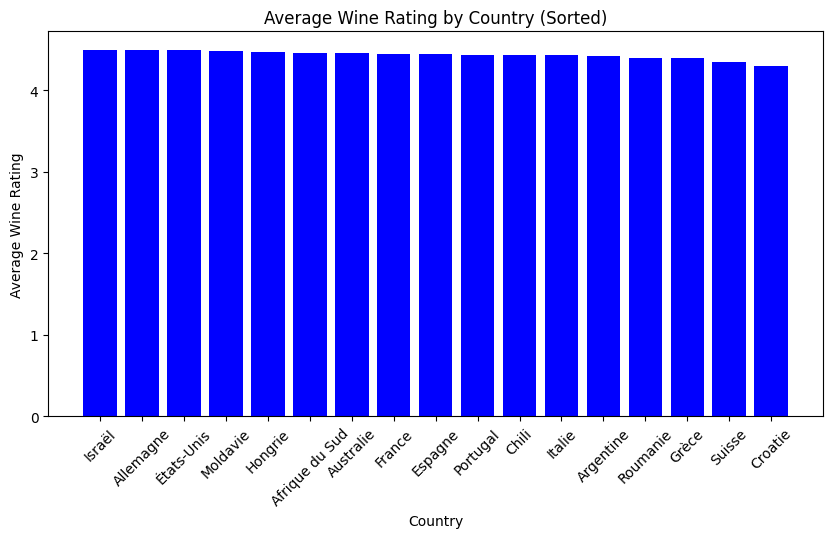

In [35]:
import matplotlib.pyplot as plt

# Assuming sorted_avg_wine_rating_by_country is fetched from the database
countries, avg_ratings = zip(*sorted_avg_wine_rating_by_country)

plt.figure(figsize=(10, 5))
plt.bar(countries, avg_ratings, color='blue')
plt.xlabel('Country')
plt.ylabel('Average Wine Rating')
plt.title('Average Wine Rating by Country (Sorted)')
plt.xticks(rotation=45)
plt.show()



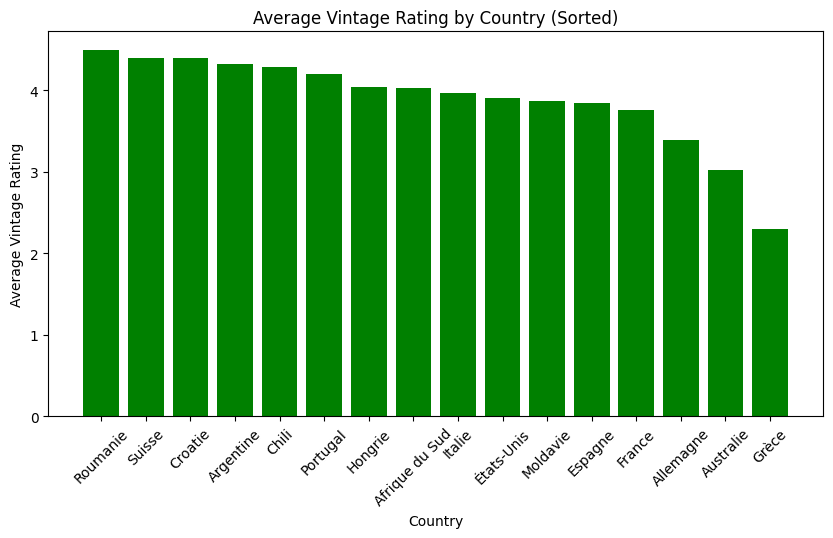

In [33]:
# Assuming sorted_avg_vintage_rating_by_country is fetched from the database
countries, avg_vintage_ratings = zip(*sorted_avg_vintage_rating_by_country)

plt.figure(figsize=(10, 5))
plt.bar(countries, avg_vintage_ratings, color='green')
plt.xlabel('Country')
plt.ylabel('Average Vintage Rating')
plt.title('Average Vintage Rating by Country (Sorted)')
plt.xticks(rotation=45)
plt.show()
